In [7]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
from scipy.optimize import leastsq,curve_fit

In [8]:
#analysis_master_path='Y:/Rb/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\

exp_id='2018_02_22_15_58_11_Red Horizontal alignment'
data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
exp_path=data_master_path+exp_date+'/'+exp_id+'/'
experiment_file='results.hdf5'
dp=exp_path
cuts = [[450],[450],[450]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
for r in range(5):
    q.set_thresholds(cuts, roi=r)

In [9]:
q.experiments[0]['variable_list']
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
q.get_thresholds()
retention = q.apply_thresholds()
#np.squeeze(retention['retention'])

In [10]:
tbl_str = "ivar:\t{0:.2f}\tretention:{1:.3f} +- {2:.3f}"
for i in range(len(retention['retention'].flatten())):
    print(tbl_str.format(
        retention['ivar'].flatten()[i],
        retention['retention'].flatten()[i],
        retention['error'].flatten()[i]
    ))

ivar:	-2500.00	retention:0.106 +- 0.006
ivar:	-2500.00	retention:0.000 +- 0.006
ivar:	-2500.00	retention:0.000 +- 0.006
ivar:	-2500.00	retention:0.000 +- 0.006
ivar:	-2500.00	retention:0.000 +- 0.006
ivar:	-2475.00	retention:0.254 +- 0.005
ivar:	-2475.00	retention:0.000 +- 0.005
ivar:	-2475.00	retention:0.000 +- 0.005
ivar:	-2475.00	retention:0.000 +- 0.005
ivar:	-2475.00	retention:0.000 +- 0.005
ivar:	-2450.00	retention:0.326 +- 0.007
ivar:	-2450.00	retention:0.008 +- 0.007
ivar:	-2450.00	retention:0.000 +- 0.007
ivar:	-2450.00	retention:0.000 +- 0.007
ivar:	-2450.00	retention:0.000 +- 0.007
ivar:	-2425.00	retention:0.558 +- 0.004
ivar:	-2425.00	retention:0.000 +- 0.004
ivar:	-2425.00	retention:0.000 +- 0.004
ivar:	-2425.00	retention:0.000 +- 0.004
ivar:	-2425.00	retention:0.000 +- 0.004
ivar:	-2400.00	retention:0.412 +- 0.009
ivar:	-2400.00	retention:0.014 +- 0.009
ivar:	-2400.00	retention:0.000 +- 0.009
ivar:	-2400.00	retention:0.000 +- 0.009
ivar:	-2400.00	retention:0.000 +- 0.009


In [11]:
def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-(x-x0)**2)/(sigma**2)))+offset
    return res

<IPython.core.display.Javascript object>


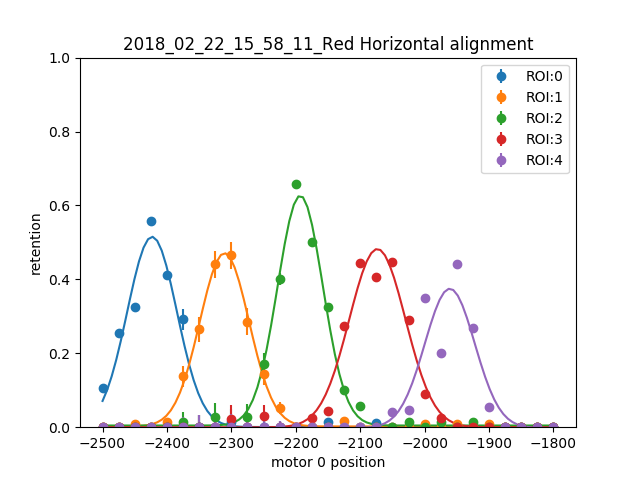

ROI:0, amplitude : 0.514841922018, location: -2423.10482343 , sigma:54.5264269822, offset:0.000515750427499
ROI:1, amplitude : 0.468839342629, location: -2310.76155138 , sigma:54.011480264, offset:0.00204452278912
ROI:2, amplitude : 0.622042528059, location: -2193.07525266 , sigma:49.6514306606, offset:0.00457321216902
ROI:3, amplitude : 0.4825766385, location: -2073.3413495 , sigma:61.6338734342, offset:-0.000249943802727
ROI:4, amplitude : 0.377012438985, location: -1960.8931022 , sigma:54.7771906406, offset:-0.00215792300146


In [12]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
fit_guesses=[0.5,-2200,50,0]
roi_dependency=[0,100,0,0]
fitted_parameters=[]
for roi in [0,1,2,3,4]:
    
    data = []
    reten = []
    err = []
    for e in range(len(np.squeeze(retention['ivar']))):
        data.append(np.squeeze(retention['ivar'])[e][roi])
        reten.append(np.squeeze(retention['retention'])[e][roi])
        err.append(np.squeeze(retention['error'])[e][roi])
    ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',color=colors[roi])
    guesses=np.add(fit_guesses,np.ones(len(fit_guesses))*(roi-2)*roi_dependency)
    fit = curve_fit(gaussian,data,reten,guesses)
    print "ROI:{}, amplitude : {}, location: {} , sigma:{}, offset:{}".format(roi,fit[0][0],fit[0][1],fit[0][2],fit[0][3])
    fitted_parameters.append(fit[0])
    #print fit[0]
    xarray=np.linspace(np.min(data),np.max(data),100)
    yfit=gaussian(xarray, np.float(fit[0][0]),np.float(fit[0][1]),np.float(fit[0][2]),np.float(fit[0][3]))
    plt.plot(xarray,yfit,color=colors[roi])

plt.show()
ax.set_title(exp_id)
ax.set_ylim(0, 1)
ax.set_xlabel(xlab)
ax.set_ylabel('retention')
ax.legend()

In [13]:
print q.experiments[0]['iterations'][0]['AAS_redside']
print q.experiments[0]['iterations'][0]['AAS_blueside']

{'sigma_y': 0.26157655377827754, 'sigma_x': 0.38346813883826564, 'error_x': 197.77853961065543, 'error_y': 10.001028461215629, 'y': 1.7456761537385432, 'x': -127.90617987021847}
{'sigma_y': 0.13018682839900875, 'sigma_x': 0.17393194648412247, 'error_x': 6.5120846497236604, 'error_y': 12.303896164664639, 'y': 12.303896164664639, 'x': 6.5120846497236604}


<IPython.core.display.Javascript object>


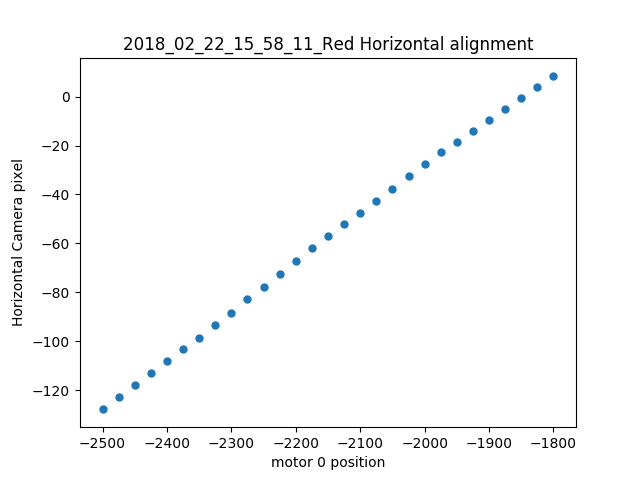

motor pos(deg):[-2500.0, -2475.0, -2450.0, -2425.0, -2400.0, -2375.0, -2350.0, -2325.0, -2300.0, -2275.0, -2250.0, -2225.0, -2200.0, -2175.0, -2150.0, -2125.0, -2100.0, -2075.0, -2050.0, -2025.0, -2000.0, -1975.0, -1950.0, -1925.0, -1900.0, -1875.0, -1850.0, -1825.0, -1800.0]
Horizontal camera location(px):[-127.90617987021847, -122.91434408728503, -118.03522743090559, -113.10197629780725, -108.04220636145567, -103.24585496802842, -98.610685474034142, -93.333786359317401, -88.420414288208576, -82.798002430304564, -77.641787795712844, -72.338141909088961, -67.03202357650548, -61.912391187975061, -57.082724821359136, -52.25546237311994, -47.42250971190208, -42.561206363162569, -37.568378511643004, -32.579557695720268, -27.701979446732025, -22.811674669422246, -18.382102232041575, -13.912026352055022, -9.6367964161369741, -5.2296985990836902, -0.50668147156011401, 4.0687555940902485, 8.6364035052174586]
Horizontal camera location err(px):[0.38346813883826564, 0.39631311689279208, 0.438776

In [15]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
xdata = []
ydata = []
yerr = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e]['AAS_redside']['x'])
    yerr.append(q.experiments[0]['iterations'][e]['AAS_redside']['sigma_x'])
ax.errorbar(xdata,ydata,yerr=yerr,fmt='o',markersize=5)

plt.show()
ax.set_title(exp_id)
#ax.set_ylim(-10, 10)
ax.set_xlabel(xlab)
ax.set_ylabel('Horizontal Camera pixel')
ax.legend()
print "motor pos(deg):{}".format(xdata)
print "Horizontal camera location(px):{}".format(ydata)
print "Horizontal camera location err(px):{}".format(yerr)


<IPython.core.display.Javascript object>


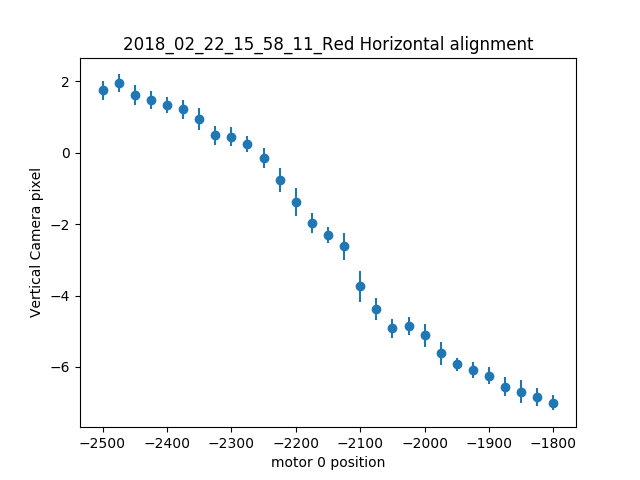

motor pos(deg):[-2500.0, -2475.0, -2450.0, -2425.0, -2400.0, -2375.0, -2350.0, -2325.0, -2300.0, -2275.0, -2250.0, -2225.0, -2200.0, -2175.0, -2150.0, -2125.0, -2100.0, -2075.0, -2050.0, -2025.0, -2000.0, -1975.0, -1950.0, -1925.0, -1900.0, -1875.0, -1850.0, -1825.0, -1800.0]
Vertical camera location(px):[1.7456761537385432, 1.9408848462915103, 1.6181228866261677, 1.4767969969391288, 1.3331666623834053, 1.2167728318821673, 0.94834698138254225, 0.48784879183980934, 0.44920524545653961, 0.23666577896568697, -0.15368088962577531, -0.7731049277726072, -1.3855879424689874, -1.9570814297936749, -2.3041035557582177, -2.6231824883088279, -3.745903590573846, -4.3713278262708286, -4.9196646609220807, -4.859113050334571, -5.1175684433689241, -5.6192770346195857, -5.9213844157897597, -6.091446445674535, -6.2469999769095637, -6.5592049558567851, -6.6930010730000618, -6.8401880401814878, -6.9983608379770885]
Vertical camera location err(px):[0.26157655377827754, 0.25277016575634881, 0.27956231806660

In [16]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
xdata = []
ydata = []
yerr = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e]['AAS_redside']['y'])
    yerr.append(q.experiments[0]['iterations'][e]['AAS_redside']['sigma_y'])
ax.errorbar(xdata,ydata,yerr=yerr,fmt='o')

plt.show()
ax.set_title(exp_id)
#ax.set_ylim(0, 1)
ax.set_xlabel(xlab)
ax.set_ylabel('Vertical Camera pixel')
ax.legend()
print "motor pos(deg):{}".format(xdata)
print "Vertical camera location(px):{}".format(ydata)
print "Vertical camera location err(px):{}".format(yerr)

ax.legend()

#  Blue camera data.

<IPython.core.display.Javascript object>


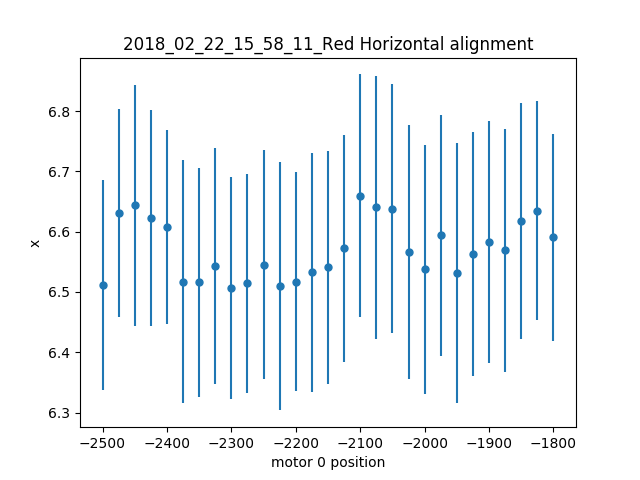

<IPython.core.display.Javascript object>


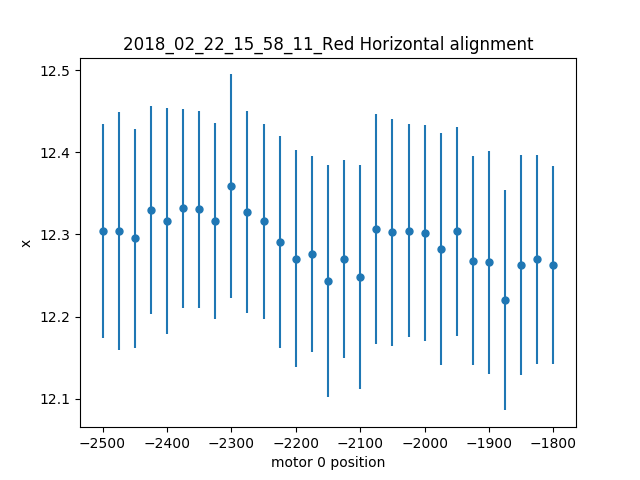

In [19]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
xdata = []
ydata = []
yerr = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e]['AAS_blueside']['x'])
    yerr.append(q.experiments[0]['iterations'][e]['AAS_blueside']['sigma_x'])
ax.errorbar(xdata,ydata,yerr=yerr,fmt='o',markersize=5)

plt.show()
ax.set_title(exp_id)
#ax.set_ylim(-10, 10)
ax.set_xlabel(xlab)
ax.set_ylabel('x')
ax.legend()

colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
xdata = []
ydata = []
yerr = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e]['AAS_blueside']['y'])
    yerr.append(q.experiments[0]['iterations'][e]['AAS_blueside']['sigma_y'])
ax.errorbar(xdata,ydata,yerr=yerr,fmt='o',markersize=5)

plt.show()
ax.set_title(exp_id)
#ax.set_ylim(-10, 10)
ax.set_xlabel(xlab)
ax.set_ylabel('x')
ax.legend()

In [21]:
np.median([1,2,3])

2.0